In [84]:
import numpy as np
import matplotlib.pyplot as plt
from skbeam.core import utils
from scipy import ndimage
from matplotlib.colors import LogNorm
from datetime import datetime
import xarray as xr

In [72]:
def dssc_correction(module_imgs):
    # order of module_imgs = [15, 0, 8, 7]
    # modified from Lingjia code
    # TODO: double check with Lingjia to make sure the positions are correct
    for i in range(4):
        if i in [1,3]:
            module_imgs[i] = np.flipud(module_imgs[i])
        else:
            module_imgs[i] = np.fliplr(module_imgs[i])
            
    drow = [9,9,2,2,159,159,152,152]
    dcol = [0,264,531,796,8,272,541,805]
    
    dssc_corrected = np.zeros((290,1061))*np.nan
    count = 0
    for i in range(4):
        for j in range(2):
            dssc_corrected[drow[count]:drow[count]+128,dcol[count]:dcol[count]+256] = module_imgs[i][:,256*j:256*j+256]
            count = count+1 
    
    im = dssc_corrected[5:-5,390:-391].copy()
    im[np.isnan(im)] = 0
    x0, y0 = ndimage.measurements.center_of_mass(im)[1], ndimage.measurements.center_of_mass(im)[0]
    center = np.array([x0,y0]).astype(int)
    return center+(390, 5), dssc_corrected


def dssc_corrected_to_module_stack(dssc_corrected):
    # order of module_imgs = [15, 0, 8, 7]
    # TODO: double check with Lingjia to make sure the positions are correct
            
    drow = [9,9,2,2,159,159,152,152]
    dcol = [0,264,531,796,8,272,541,805]
    
    module_imgs = np.zeros((4, 128, 512))*np.nan
    count = 0
    for i in range(4):
        for j in range(2):
            module_imgs[i][:,256*j:256*j+256] = dssc_corrected[drow[count]:drow[count]+128,dcol[count]:dcol[count]+256]
            count = count+1 
            
    for i in range(4):
        if i in [1,3]:
            module_imgs[i] = np.flipud(module_imgs[i])
        else:
            module_imgs[i] = np.fliplr(module_imgs[i])
    
    
    return module_imgs

In [19]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

field = current[0]
run = runNB[0]
group = 0

pm = np.zeros((4, 128, 512))*np.nan
for i, module in enumerate(modules):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[:10].mean(axis=(0,1))
    pm[i] = photon_maps

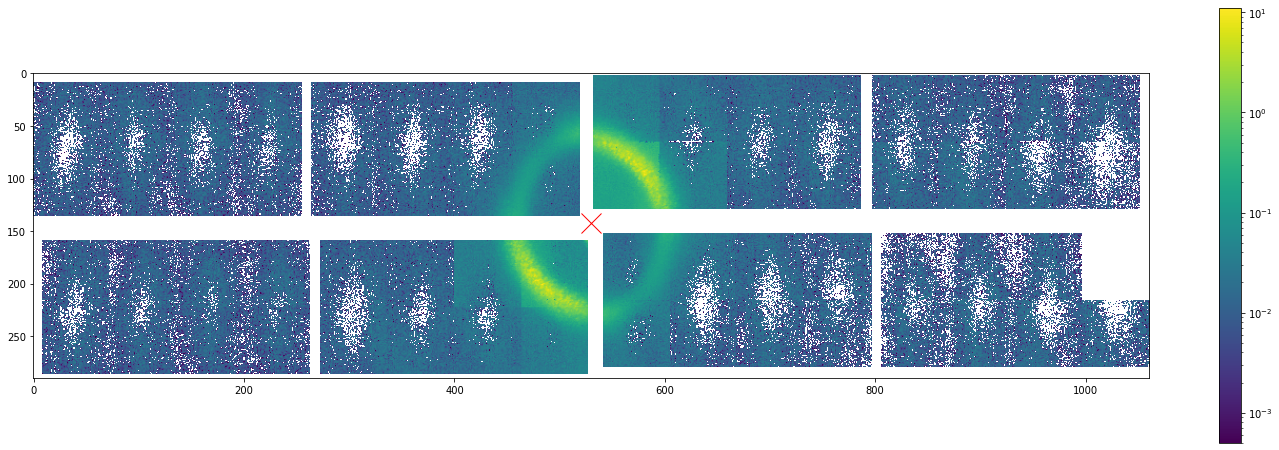

In [53]:
center, img = dssc_correction(pm.copy())

plt.figure(figsize=(25,10))
plt.imshow(img, norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.plot(center[0], center[1], 'rx', markersize=20)
plt.show()

In [58]:
shape = img.shape
pixel_size = (204e-6, 236e-6) # m
sample_distance = 2.8 # m
wavelength = (1240/707) #nm Fe L3

q_grid = utils.twotheta_to_q(utils.radius_to_twotheta(sample_distance, utils.radial_grid(center[::-1], shape, pixel_size)), wavelength)
angle_grid = utils.angle_grid(center[::-1], shape)

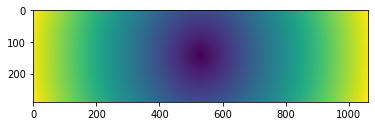

In [59]:
plt.imshow(q_grid)

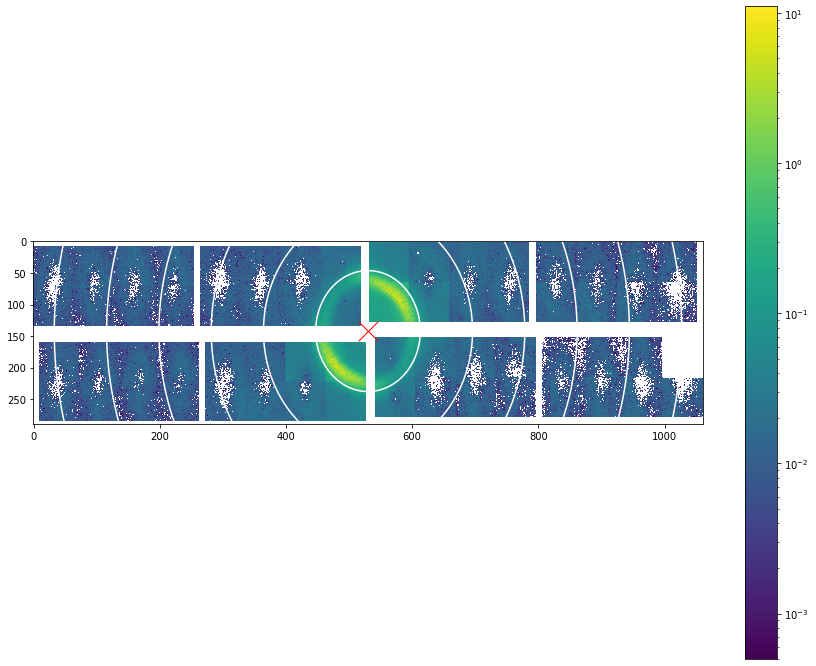

In [60]:
plt.figure(figsize=(15,15))
plt.imshow(img, norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.plot(center[0], center[1], 'rx', markersize=20)
plt.contour(q_grid, colors=['w'])
plt.show()

In [61]:
q_bins = np.linspace(np.amin(q_grid), np.amax(q_grid), 50)
angle_bins = np.linspace(np.amin(angle_grid), np.amax(angle_grid), 50)
q_discrete = np.digitize(q_grid, q_bins, right=True)
angle_discrete = np.digitize(angle_grid, angle_bins, right=True)

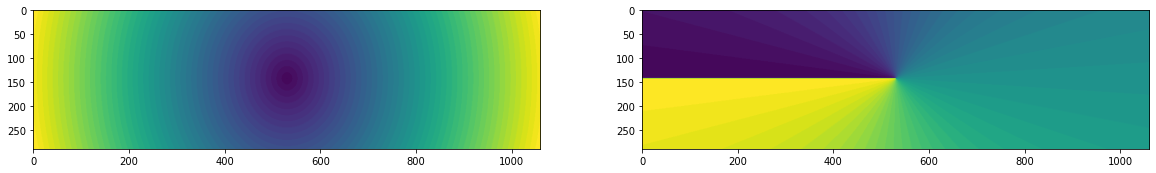

In [62]:
fig, ax= plt.subplots(figsize=(20,10), ncols=2)
ax[0].imshow(q_discrete)
ax[1].imshow(angle_discrete)
plt.show()

In [69]:
grid = q_discrete + angle_discrete * 0.5

labels = np.zeros(grid.shape, dtype=int)
for i, u in enumerate(np.unique(grid)):
    labels[grid==u] = i

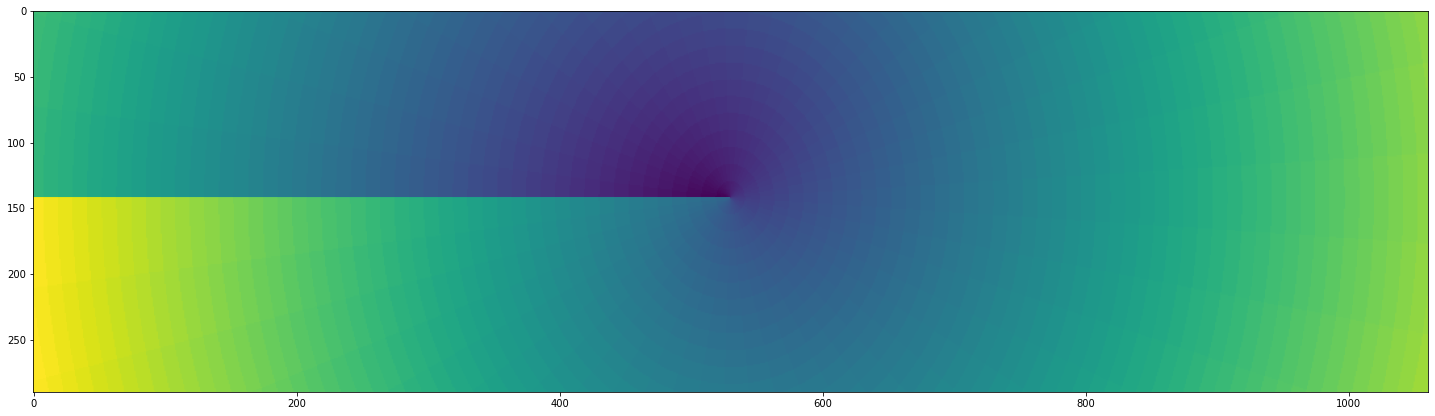

In [70]:
plt.figure(figsize=(25,10))
plt.imshow(labels)
plt.show()

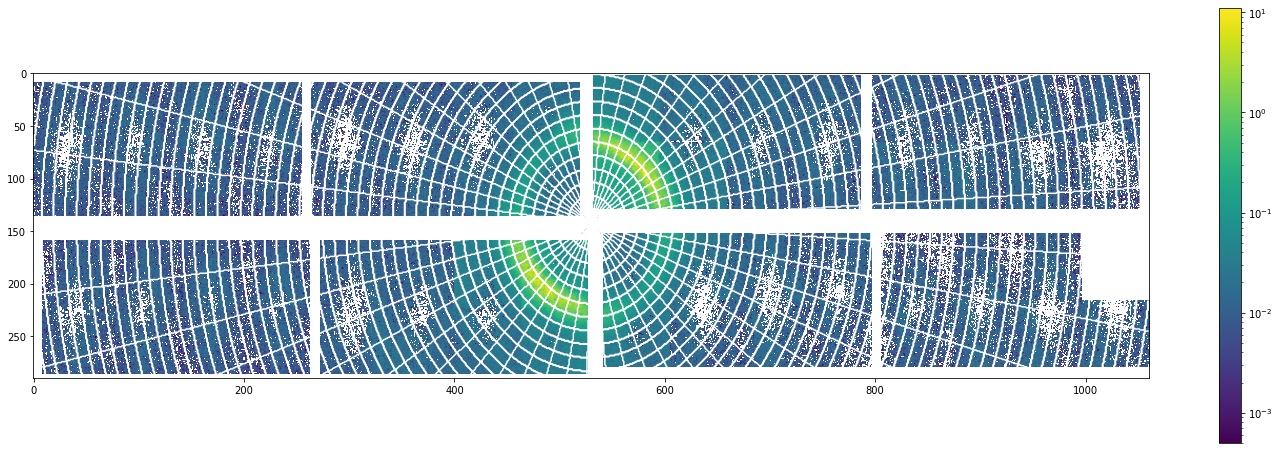

In [71]:
plt.figure(figsize=(25,10))
plt.imshow(img, norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.plot(center[0], center[1], 'rx', markersize=20)
plt.contour(labels, colors=['w'], levels=len(np.unique(labels)))
plt.show()

In [86]:
module_labels = dssc_corrected_to_module_stack(labels.copy())
q_stacks = dssc_corrected_to_module_stack(q_discrete.copy())
angle_stacks = dssc_corrected_to_module_stack(angle_discrete.copy())

In [87]:
module_labels.shape

(4, 128, 512)

In [90]:
ds = xr.Dataset(
        data_vars={'labels': (('module', 'row', 'col'), module_labels),
                   'q_grid': (('module', 'row', 'col'), q_stacks),
                   'angle_grid': (('module', 'row', 'col'), angle_stacks)
                  },
        attrs={'run_number': run,
               'magnet_current': field,
               'module_order': modules,
               'date_processed': datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
              }
    )    
ds

<xarray.Dataset>
Dimensions:     (module: 4, row: 128, col: 512)
Dimensions without coordinates: module, row, col
Data variables:
    labels      (module, row, col) float64 31.0 31.0 31.0 ... 118.0 118.0 118.0
    q_grid      (module, row, col) float64 11.0 11.0 11.0 ... 48.0 48.0 48.0
    angle_grid  (module, row, col) float64 12.0 12.0 12.0 ... 25.0 25.0 25.0
Attributes:
    run_number:      70
    magnet_current:  0.0
    module_order:    [15, 0, 8, 7]
    date_processed:  08/23/2024, 19:12:28

In [91]:
ds.to_netcdf(f'./labels.h5', engine='h5netcdf')